In [2]:
import sys
print(sys.executable)

/Users/marcbagurvizoso/finance-env/bin/python


# Cross-Asset Correlation Anomaly Detector

This notebook implements a full workflow to:

- Download historical price data for multiple assets (equities, bonds, commodities, FX proxies, etc.)
- Compute daily log returns
- Compute rolling correlations between each pair of assets
- Measure how unusual the current correlation is using z-scores
- Flag correlation anomalies (large deviations from historical behavior)
- Visualize correlation regimes and anomaly points

All code explanations are given with comments like `# note: ...`.

**IMPORTS AND GLOBAL SETTINGS**

In [4]:
# note: import core libraries for data handling, downloading data and plotting
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# display plots inline
%matplotlib inline

# note: list of tickers to analyze; feel free to change/add more
TICKERS = ["SPY", "TLT", "GLD", "USO"]

# note: analysis parameters
START_DATE = "2015-01-01"   # start date for historical data
WINDOW = 60                 # rolling window length in days
THRESHOLD_Z = 2.0           # z-score threshold to flag anomalies

**DOWNLOAD PRICE DATA FUNCTION**

In [5]:
# note: this function downloads adjusted closing prices from Yahoo Finance
def download_price_data(tickers, start_date):
    """
    Download adjusted close prices for a list of tickers from Yahoo Finance.

    Parameters
    ----------
    tickers : list[str]
        List of asset tickers.
    start_date : str
        Start date for historical data.

    Returns
    -------
    pd.DataFrame
        DataFrame of adjusted close prices.
    """
    data = yf.download(tickers, start=start_date, auto_adjust=True)["Close"]
    
    # if only one ticker is passed, ensure output is a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    return data

# download the data
price_data = download_price_data(TICKERS, START_DATE)
price_data.tail()

[*********************100%***********************]  4 of 4 completed


Ticker,GLD,SPY,TLT,USO
Date,,,,
2025-11-24,380.200012,668.729980,89.689713,70.419998
2025-11-25,380.079987,675.020020,89.918892,69.250000
2025-11-26,383.119995,679.679993,90.317474,70.040001
2025-11-28,387.880005,683.390015,89.889000,71.070000
2025-12-01,389.750000,680.270020,88.769997,71.059998


**COMPUTE LOG RETURNS**

In [6]:
# note: compute daily log returns
def compute_log_returns(price_df):
    """
    Compute daily log returns: r_t = ln(P_t / P_{t-1}).
    """
    returns = np.log(price_df / price_df.shift(1))
    return returns.dropna()

returns = compute_log_returns(price_data)
returns.tail()

Ticker,GLD,SPY,TLT,USO
Date,,,,
2025-11-24,0.015720,0.014611,0.005682,0.016032
2025-11-25,-0.000316,0.009362,0.002552,-0.016754
2025-11-26,0.007967,0.006880,0.004423,0.011343
2025-11-28,0.012348,0.005444,-0.004755,0.014599
2025-12-01,0.004809,-0.004576,-0.012527,-0.000141


**ROLLING CORRELATION FUNCTION**

In [7]:
# note: compute rolling correlation between two assets
def rolling_correlation_pair(returns_df, ticker_a, ticker_b, window):
    """
    Rolling correlation between two assets over a given window.
    """
    corr_series = returns_df[ticker_a].rolling(window).corr(returns_df[ticker_b])
    return corr_series.dropna()

# test with an example pair
example_pair = ("SPY", "TLT")
corr_example = rolling_correlation_pair(returns, example_pair[0], example_pair[1], WINDOW)
corr_example.tail()

Date
2025-11-24   -0.122372
2025-11-25   -0.144363
2025-11-26   -0.156167
2025-11-28   -0.185965
2025-12-01   -0.139666
dtype: float64

**Z-SCORE AND ANOMALY DETECTION FUNCTIONS**

In [8]:
# note: compute z-scores of a correlation series
def compute_corr_zscore(corr_series):
    """
    Compute z-score of correlation time series.
    """
    mean_corr = corr_series.mean()
    std_corr = corr_series.std()
    z_score = (corr_series - mean_corr) / std_corr
    return z_score, mean_corr, std_corr


# note: detect anomalies based on |z|
def detect_anomalies_from_z(z_score_series, threshold):
    """
    Return dates where |z-score| exceeds the threshold.
    """
    return z_score_series[abs(z_score_series) > threshold]


# test on example pair
z_example, mean_example, std_example = compute_corr_zscore(corr_example)
anomalies_example = detect_anomalies_from_z(z_example, THRESHOLD_Z)

z_example.tail(), anomalies_example.tail()

(Date
 2025-11-24    0.186580
 2025-11-25    0.108914
 2025-11-26    0.067226
 2025-11-28   -0.038016
 2025-12-01    0.125502
 dtype: float64,
 Date
 2023-12-05    2.013671
 2023-12-13    2.053422
 2023-12-14    2.074132
 2024-07-10    2.017190
 2025-07-08    2.031868
 dtype: float64)

**PLOTTING FUNCTION**

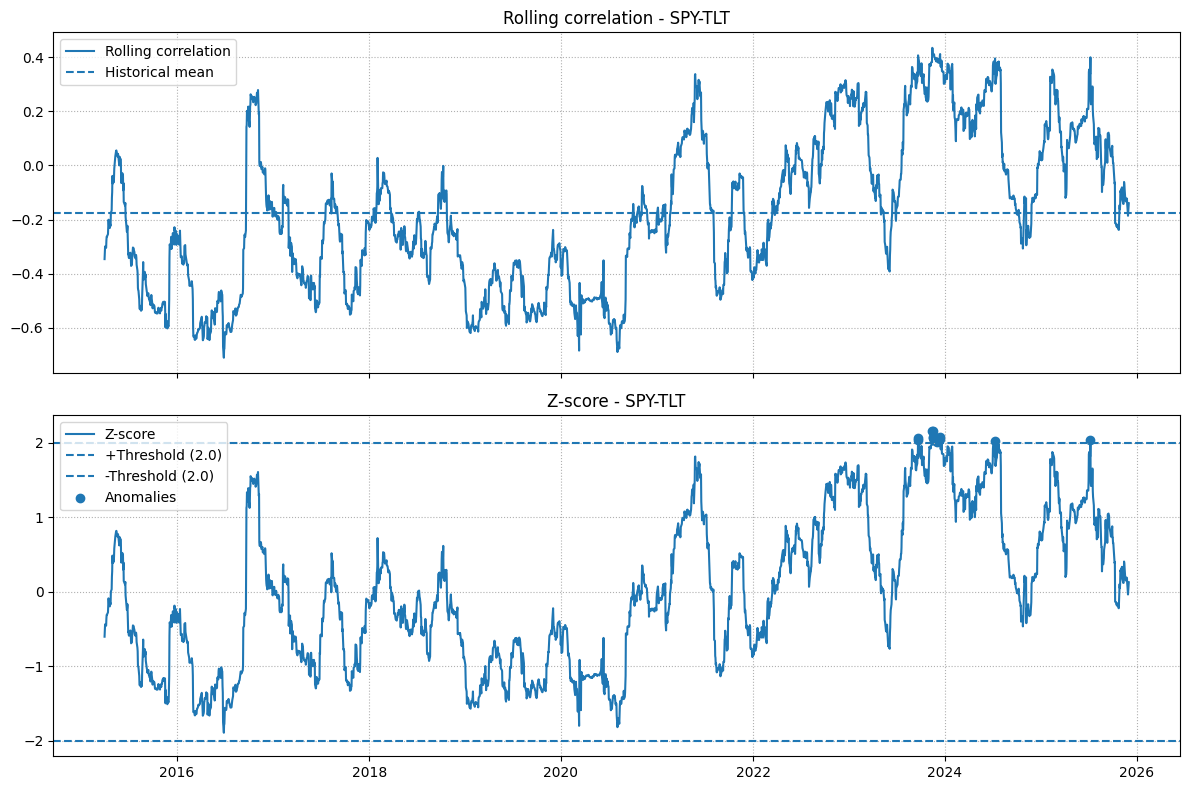

In [9]:
def plot_corr_and_zscore(corr_series, z_score_series, anomalies, mean_corr, threshold, pair_name):
    """
    Plot rolling correlation and corresponding z-score with anomaly markers.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # plot 1: correlation
    axes[0].plot(corr_series.index, corr_series.values, label="Rolling correlation")
    axes[0].axhline(mean_corr, linestyle="--", label="Historical mean")
    axes[0].set_title(f"Rolling correlation - {pair_name}")
    axes[0].legend()
    axes[0].grid(True, linestyle=":")

    # plot 2: z-score
    axes[1].plot(z_score_series.index, z_score_series.values, label="Z-score")
    axes[1].axhline(threshold, linestyle="--", label=f"+Threshold ({threshold})")
    axes[1].axhline(-threshold, linestyle="--", label=f"-Threshold ({threshold})")
    axes[1].scatter(anomalies.index, anomalies.values, marker="o", label="Anomalies")
    axes[1].set_title(f"Z-score - {pair_name}")
    axes[1].legend()
    axes[1].grid(True, linestyle=":")

    plt.tight_layout()
    plt.show()


# plot example pair
plot_corr_and_zscore(
    corr_series=corr_example,
    z_score_series=z_example,
    anomalies=anomalies_example,
    mean_corr=mean_example,
    threshold=THRESHOLD_Z,
    pair_name=f"{example_pair[0]}-{example_pair[1]}"
)

**GLOBAL ANOMALY DETECTION FOR ALL PAIRS**

In [10]:
from itertools import combinations

def detect_corr_anomalies_for_universe(returns_df, window, threshold):
    """
    Detect correlation anomalies for all asset pairs.
    """
    results = []

    for a, b in combinations(returns_df.columns, 2):
        corr_series = rolling_correlation_pair(returns_df, a, b, window)
        
        if len(corr_series) < 10:
            continue
        
        z_score, mean_corr, std_corr = compute_corr_zscore(corr_series)
        anomalies = detect_anomalies_from_z(z_score, threshold)

        results.append({
            "pair": f"{a}-{b}",
            "mean_corr": mean_corr,
            "std_corr": std_corr,
            "last_corr": corr_series.iloc[-1],
            "last_z": z_score.iloc[-1],
            "n_anomalies": len(anomalies),
            "last_anomaly_date": anomalies.index[-1] if len(anomalies) else None
        })
    
    df = pd.DataFrame(results)
    return df.sort_values(by="last_z", key=lambda s: s.abs(), ascending=False)

summary_table = detect_corr_anomalies_for_universe(returns, WINDOW, THRESHOLD_Z)
summary_table.head()

,pair,mean_corr,std_corr,last_corr,last_z,n_anomalies,last_anomaly_date
1,GLD-TLT,0.321008,0.193242,0.023425,-1.539958,48,2025-05-07
2,GLD-USO,0.112339,0.192730,-0.049757,-0.841053,134,2022-12-05
0,GLD-SPY,0.004112,0.278785,0.178190,0.624417,84,2025-07-14
5,TLT-USO,-0.192837,0.167871,-0.279126,-0.514020,60,2022-05-04
4,SPY-USO,0.257762,0.221538,0.182084,-0.341600,126,2025-10-03


**ANALYZE AND PLOT STRONGEST ANOMALY**

In [11]:
# pick the pair with the highest |z-score|
top_pair = summary_table.iloc[0]["pair"]
top_pair

'GLD-TLT'

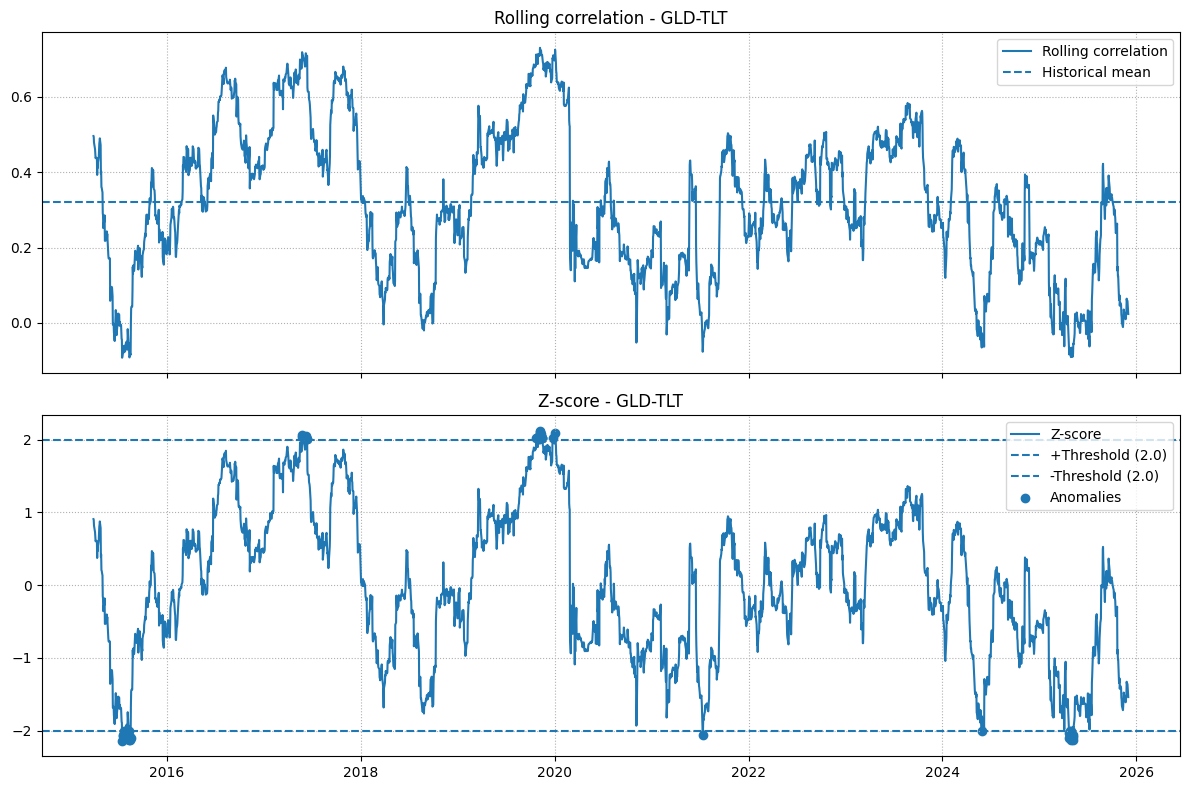

In [12]:
# split the pair
a, b = top_pair.split("-")

corr_top = rolling_correlation_pair(returns, a, b, WINDOW)
z_top, mean_top, std_top = compute_corr_zscore(corr_top)
anom_top = detect_anomalies_from_z(z_top, THRESHOLD_Z)

plot_corr_and_zscore(
    corr_series=corr_top,
    z_score_series=z_top,
    anomalies=anom_top,
    mean_corr=mean_top,
    threshold=THRESHOLD_Z,
    pair_name=top_pair
)